In [1]:
import numpy as np
import os, json
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
# from numba import njit
# NOTE: Some codes are written in a c style with a poor performance, but they can be boosted significantly by numba!!!

In [2]:
pi = np.pi
mass_u = 0.93141941 # GeV
def nucleus_data_gen(name, A, Z):
    N = A-Z
    return {"basic name": name, "name": name+str(A), "A": A, "Z": Z, "N": N, "M": A*mass_u, "AZN": (A,Z,N), 'ZN': (Z,N)}
nucleus_data_list = [['Xe', 131, 54], ['Cs', 133, 55], ['I', 127, 53]]
nucleus_dict = {nucleus_data_gen(*d)['name']: nucleus_data_gen(*d) for d in nucleus_data_list}

def response_gen(E_r: np.ndarray, Nuc: str):
    """intitalization

        Parameters
        ----------
        E_r : np.ndarray(1)
            recoil energies

        Returns
        -------
        response : np.ndarray(3)
            (8,4,len(E_r)): [["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP", "Delta", "DeltaSigmaP"], ["pp", "pn", "np", "nn"]], [u,d,s]
        """ 
    m_A = Nuc['M']
    file_path = os.path.join(os.getcwd(), 'pyNucleusResponse.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    nucleus_dict = data[Nuc['name']] 
    b = nucleus_dict['basic']['b']
    u = m_A*b*b*E_r
    u_mat = np.array([u**i for i in range(0,15)])
    exp_list = np.exp(-u)
    def response_func(response, nucleon2):
        polynomial_coefficent_list = nucleus_dict[response][nucleon2]
        polynomial_list = polynomial_coefficent_list@(u_mat[:len(polynomial_coefficent_list)])
        return exp_list*polynomial_list
    
    response_list = ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP", "Delta", "DeltaSigmaP"]
    pn_list = ["pp", "pn", "np", "nn"]
    response_Er = np.array([[response_func(response_list[i], pn_list[j]) for j in range(len(pn_list))] for i in range(len(response_list))])
    return response_Er

seconds2year = 365.25*3600*24
N_A = 6.02214e23 # Avocado's constant
G_F_GeV = 1.16637e-5 # GeV**-2 Fermi constan in GeV
class CEvNS_GNI_response_tensor(object):
    def __init__(self, nu: dict, detector: dict):
        """intitalization

        Parameters
        ----------
        detector : dict
            {'E_r': np.ndarray(1), 'Nuc': str}

        Returns
        -------
        dR_dE : np.ndarray
            (len(E_r)): event rates
        """ 
        # detector: [E_r, Nuc]
        E_r = detector['E_r']
        Nuc = nucleus_dict[detector['Nuc']]
        A, self._m_A = Nuc['A'], Nuc['M']
        self.Nuc, self._E_r = Nuc, E_r

        factor = 8.0
        factor_diff_sigma = (self._m_A/(pi*factor))*(1.973e-14)**2.0
        # Convert into /ton/year/GeV
        total_factor = factor_diff_sigma*1000*seconds2year/(A)*(N_A)*1000.0
        self._total_factor = total_factor
        FF = response_gen(E_r, Nuc) # FF: Form Factor like

        flavor_index_dict = {"e": 0, "e_bar": 0, "mu": 1, "mu_bar": 1, "tau": 2, "tau_bar": 2}
        self._flavor_index = flavor_index_dict[nu["flavor"]]
        self._quark_to_nucleon_init()
        self._FF = FF

        self._mN_q2 = mass_u/(2*self._m_A*E_r)
    
    def _quark_to_nucleon_init(self, f_12_ud=np.array([[0.784, -0.204],[-1.5,0.5]])):
        """generate resource for all nucleon form factors

        Parameters
        ----------
        f_12_ud : np.ndarray(2)
            (2,2): [f_1, f_2], [u, d]

        Returns
        -------
        self._SPVAT_CD_pn_uds : np.ndarray
            (2,2,2): [ft1,ft2], [p,n], [u,d]
        """ 
        quark2nucleon_dict = {"T": {"f1": {"p": f_12_ud[0], "n": f_12_ud[0,::-1]},
                                    "f2": {"p": f_12_ud[1], "n": f_12_ud[1,::-1]}},}
        T_pn_ud = np.array([[quark2nucleon_dict["T"]["f1"]["p"], quark2nucleon_dict["T"]["f1"]["n"]],
                            [quark2nucleon_dict["T"]["f2"]["p"], quark2nucleon_dict["T"]["f2"]["n"]]])
        self._T_pn_ud = T_pn_ud
    
    def cross_section(self, E_nu: float, model_para, misc={"mode": "total"}):
        """generate cross section by given model parameters and mode

        Parameters
        ----------
        E_nu : float
            incident neutrino energy

        model_para : np.ndarray(2)
            (3,3): [e,mu,tau], [u,d,s]

        misc : dict
            {"mode": control the output: total or vMM}

        Returns
        -------
        cross section : np.ndarray(2)
            (6,len(E_r)): ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP"], [E_r]
        """ 
        element_para_list = CEvNS_cross_section_response_tensor_para_gen(model_para, self._T_pn_ud, self._mN_q2, self._flavor_index, misc)
        cross_section_list = CEvNS_cross_section_tensor_gen(self._E_r, np.array([E_nu]), self._FF, self._m_A, mass_u)
        tensor_res = np.einsum('ijk,ijk->ik',element_para_list,cross_section_list)
        
        factor=8.0
        factor_diff_sigma = (self._m_A/(pi*factor))*(1.973e-14)**2.0
        return factor_diff_sigma*tensor_res

def CEvNS_cross_section_response_tensor_para_gen(model_para, pn_uds, mN_q2, flavor_index, misc={"mode": "total"}):
    """generate tensor para

        Parameters
        ----------
        model_para : np.ndarray(2)
            (3,3): [e,mu,tau], [u,d,s]
            
        pn_uds : np.ndarray(3)
            
        mN_q2 : np.ndarray(1)

        misc : dict
            {"mode": control the output: total or vMM}

        Returns
        -------
        tensor_para : np.ndarray(3)
            (6,4,len(E_r)): ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP"], ['pp', 'pn', 'np', 'nn'], [E_r]
        """ 
    def CEvNS_cross_section_response_tensor_para_gen_sub(N_1_pn, N_2_pn):
        len_E_r = N_1_pn.shape[-1]
        res = np.zeros((4, len_E_r))
        for i in range(2):
            for j in range(2):
                res[i*2+j] = N_1_pn[i]*N_2_pn[j]
        return res
    def tensor_induced_neutrino_MM(ep_x, ep_y):
        m_ud = np.array([2.16e-3, 4.67e-3])
        Q_ud = np.array([2.,-1.])/3.
        # G_F_GeV = 1.1663787e-5
        m_e = 0.511e-3
        pi = np.pi
        Nc = 3
        factor = Nc*m_e*Q_ud*m_ud/pi**2
        ep_T = np.zeros(2)
        
        ep_T = np.array([ep_x,ep_y])
        ep_T = np.where(np.abs(ep_T-0.)<=1e-20,1e-20,ep_T)
        # res = np.sum(ep_T*factor*np.log(np.abs(ep_T)*m_ud**2))
        res = np.sum(ep_T*factor*(1.+np.log(np.abs(ep_T)*m_ud**2)))
        return res
    # model_para (3,2): [e,mu,tau], [u,d]
    len_E_r = mN_q2.shape[-1]
    model_para_flavor = model_para[flavor_index].copy()
    GT1 = np.zeros((2,len_E_r))
    GT2 = np.zeros((2,len_E_r))
    GTV = np.zeros((2,len_E_r))
    c0 = np.zeros((2,len_E_r))
    for i in range(2):
        GT1[i] = np.dot(pn_uds[0,i], model_para_flavor)
        GT2[i] = np.dot(pn_uds[1,i], model_para_flavor)
    e = np.sqrt(4*np.pi/137.0)
    m_e = 0.511e-3
    mu_B = e/(2*m_e)
    GTV[0] = tensor_induced_neutrino_MM(model_para_flavor[0], model_para_flavor[1])*e*mu_B

    if misc["mode"] == "total":
        pass
    elif misc["mode"] == "vMM":
        GT1 = np.zeros((2,len_E_r))
        GT2 = np.zeros((2,len_E_r))

    for i in range(2):
        c0[i] = -GT1[i]+2*GT2[i]+mN_q2*GTV[i]

    coef_terms_pn = np.zeros((6, 4, len_E_r))
    coef_terms_pn[0] = CEvNS_cross_section_response_tensor_para_gen_sub(c0, c0)
    coef_terms_pn[1] = CEvNS_cross_section_response_tensor_para_gen_sub(GT1, GT1)
    coef_terms_pn[2] = coef_terms_pn[1]
    coef_terms_pn[3] = coef_terms_pn[1]
    coef_terms_pn[4] = coef_terms_pn[1]
    coef_terms_pn[5] = CEvNS_cross_section_response_tensor_para_gen_sub(c0, GT1)
    return coef_terms_pn

# @njit
def CEvNS_cross_section_tensor_gen(E_r, E_nu, FF, m_A, mN):
    """generate cross section except a factor

        Parameters
        ----------
        E_r, E_nu

        FF : np.ndarray(3)
            (8,4,len(E_r)): [["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP", "Delta", "DeltaSigmaP"], ["pp", "pn", "np", "nn"], [u,d,s]]

        m_A: nucleus mass, mN: nucleon mass

        Returns
        -------
        cross section : np.ndarray(3)
            (6,4,len(E_r)): ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP"], ["pp", "pn", "np", "nn"], [E_r]
        """ 
    len_E_r, len_E_nu = E_r.shape[0], E_nu.shape[0]
    len_kinetic_basis = 4
    # ========== obtain the differential rates without form factors ========= #
    diff_sigma_E_r_i_basis = np.zeros((len_kinetic_basis,len_E_r))
    diff_sigma_E_r_i_E_nu = np.zeros((len_E_r, len_kinetic_basis, len_E_nu))  # Preallocate the array
    E_r_E_nu = np.zeros(len_E_nu)
    # l0l0: (q/mN)^2 Ev^2 (1-T/Ev)
    # l5l5 l: Ev^2 (1-T/Ev)
    # l5l5 t: Ev^2 (1-MT/2Ev^2-T/Ev)
    # lElE l ((q/mN)^2): (q/mN)^2 Ev^2 (1-T/Ev) [x]
    # lElE t ((q/mN)^2): (q/mN)^2 Ev^2 (1-MT/2Ev^2-T/Ev)
    # l0lE l ((q/mN)): (q/mN)^2 Ev^2 (1-T/Ev) [x]
    # keys = ["(q/mN)^2 Ev^2 (1-T/2Ev)", "Ev^2 (1-T/Ev)", "Ev^2 (1-MT/2Ev^2-T/Ev)", "(q/mN)^2 Ev^2 (1-MT/2Ev^2-T/Ev)"]
    q2_mN2 = 2*m_A*E_r/mN**2
    for i in range(len_E_r):
        E_r_E_nu = E_r[i]/E_nu
        ME_r_E_nu2 = m_A*E_r[i]/(E_nu**2.0)
        for j in range(len_E_nu):
            if E_nu[j]>0.5*(E_r[i] + np.sqrt(E_r[i]**2.0 + 2.0*m_A*E_r[i])):
                diff_sigma_E_r_i_E_nu[i,0,j] = q2_mN2[i]*(1-E_r_E_nu[j])
                diff_sigma_E_r_i_E_nu[i,1,j] = 1-E_r_E_nu[j]
                diff_sigma_E_r_i_E_nu[i,2,j] = 1-0.5*ME_r_E_nu2[j]-E_r_E_nu[j]
                diff_sigma_E_r_i_E_nu[i,3,j] = q2_mN2[i]*diff_sigma_E_r_i_E_nu[i,2,j] 
            else:
                diff_sigma_E_r_i_E_nu[i,:,j] = 0.0
    
    diff_sigma_E_r_i_basis = diff_sigma_E_r_i_E_nu[:,:,0].transpose()
    # ========== sort the differential rates with form factors ========= #
    len_terms, len_pn = 6, 4
    diff_sigma = np.zeros((len_terms,len_pn,len_E_r))
    terms_factors = np.array([4., 16., 8., 16., 8., 2*8.])
    # FF: (8, 4): ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP", "Delta", "DeltaSigmaP"], ["pp", "pn", "np", "nn"]
    for j in range(len_pn):
        diff_sigma[0,j] = terms_factors[0]*diff_sigma_E_r_i_basis[0]*FF[0,j] # l0l0
        diff_sigma[1,j] = terms_factors[1]*diff_sigma_E_r_i_basis[1]*FF[1,j] # l5l5 l
        diff_sigma[2,j] = terms_factors[2]*diff_sigma_E_r_i_basis[2]*FF[2,j] # l5l5 t
        diff_sigma[3,j] = terms_factors[3]*diff_sigma_E_r_i_basis[0]*FF[3,j] # lElE l
        diff_sigma[4,j] = terms_factors[4]*diff_sigma_E_r_i_basis[3]*FF[4,j] # lElE t
        diff_sigma[5,j] = terms_factors[5]*diff_sigma_E_r_i_basis[0]*FF[5,j] # l0lE l
    return diff_sigma

COHERENT threshold: 14.527348473259586 keV, B8 threshold: 1.6527920614648972 keV


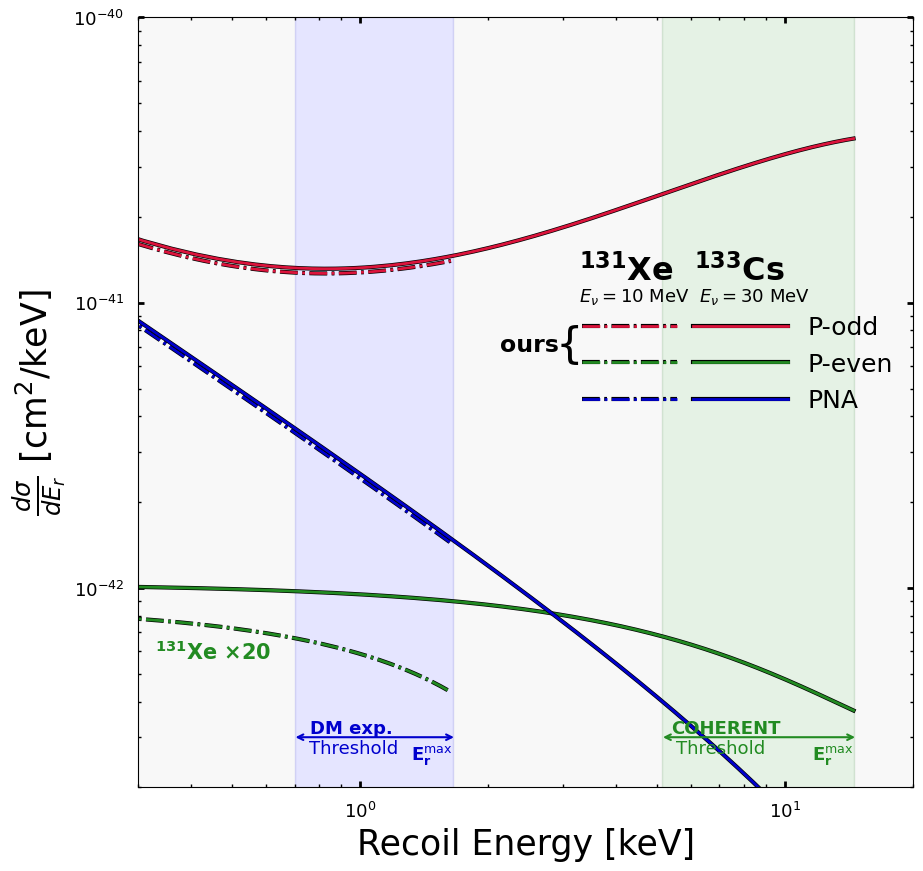

In [3]:
def tensor_cross_section_gen(Nuc, E_r, E_nu, model_para_tensor, misc={"mode": "total"}):
    """generate cross section for Cs

        Parameters
        ----------
        model_para : np.ndarray(2)
            (3,3): [e,mu,tau], [u,d,s]

        misc : dict
            {"mode": control the output: total or vMM}

        Returns
        -------
        cross section : np.ndarray(2)
            (6,len(E_r)): ["M", "SigmaPP", "SigmaP", "PhiPP", "PhiPT", "MPhiPP"], [E_r]
        """ 
    E_nu_array = np.array([E_nu])
    source = {"name": "COHERENT", "mono": True, "flavor": "mu", "E_nu": E_nu_array, "flux": np.ones_like(E_nu_array),}
    tensor_class = CEvNS_GNI_response_tensor(source, {"E_r": E_r, "Nuc": Nuc})
    tensor_res = tensor_class.cross_section(E_nu, model_para_tensor,misc)
    return tensor_res

def response_tensor_epGen_FI(ep_dict):
    """generate tensor couplings

        Parameters
        ----------
        ep_dict : dict
            {quark flavor index: value}

        Returns
        -------
        model_para : np.ndarray(2)
            (3,3): [e,mu,tau], [u,d,s]
        """ 
    epMat = np.zeros((3,2))
    for key, value in ep_dict.items():
        epMat[:,key] = value
    return epMat

def tensor_cross_section():
    # plot function
    keVtoPE = 1.17
    GeVtoPE = 1e6*keVtoPE
    ROI_range = [x/GeVtoPE*1e6 for x in [6., 60.]]

    E_r = np.linspace(1e-6/GeVtoPE, 60./GeVtoPE, 1000) # GeV
    E_r_B8 = np.logspace(-3-6, 2-6, 1000) # GeV
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    Ev = 30*1e-3 # GeV
    Ev_B8 = 10e-3 # GeV
    def a_plot(ax, epT_u, epT_d):
        response_model_para = response_tensor_epGen_FI({0: epT_u, 1: epT_d})
        tensor_COHERENT_temp = tensor_cross_section_gen('Cs133',E_r, Ev, response_model_para, misc={"mode": "total"})
        vMM_COHERENT = tensor_cross_section_gen('Cs133',E_r, Ev, response_model_para, misc={"mode": "vMM"})[0]
        # print(vMM_COHERENT)
        tensor_COHERENT = np.zeros((6,len(E_r)))
        tensor_COHERENT[0] = np.sum(tensor_COHERENT_temp, axis=0)
        tensor_COHERENT[1] = np.sum(tensor_COHERENT_temp[np.array([0,5,3])], axis=0)
        tensor_COHERENT[2] = np.sum(tensor_COHERENT_temp[np.array([1,2])], axis=0)
        tensor_COHERENT[3] = vMM_COHERENT

        tensor_B8_temp = tensor_cross_section_gen('Xe131',E_r_B8, Ev_B8, response_model_para, misc={"mode": "total"})
        vMM_8B = tensor_cross_section_gen('Xe131', E_r_B8, Ev_B8, response_model_para, misc={"mode": "vMM"})[0]
        # print(tensor_B8[0])
        tensor_B8 = np.zeros((6,len(E_r_B8)))
        tensor_B8[0] = np.sum(tensor_B8_temp, axis=0)
        tensor_B8[1] = np.sum(tensor_B8_temp[np.array([0,5,3])], axis=0)
        tensor_B8[2] = np.sum(tensor_B8_temp[np.array([1,2])], axis=0)
        tensor_B8[3] = vMM_8B
        
        #==================== plot setup ======================#
        plot_range = [[3e-1,20], [2e-43,1e-40]]
        xy_label = [r"Recoil Energy [keV]", r'$\frac{d\sigma}{d E_r}$ [cm$^{2}$/keV]']
        # xy_label = [r"Recoil Energy [keV]", r'Event Rates [keV$\times$ton$\times$year$^{-1}$]']
        xy_scale = ['log', 'log']
        label_font_size = 25
        ax.set(xscale=xy_scale[0], yscale=xy_scale[1], xlim=plot_range[0], ylim=plot_range[1])
        ax.set_xlabel(xy_label[0],fontsize=label_font_size)
        ax.set_ylabel(xy_label[1],fontsize=label_font_size)
        ax.tick_params(which='major',direction='in',width=2,length=4,pad=10,right=True,top=True,labelsize=13)
        ax.tick_params(which='minor',direction='in',width=1,length=2,right=True,top=True)

        labelList = [r'P-odd', r'P-even', r'PNA', r'$\nu$MM']
        # colorList = ['black', 'r', 'g', 'b', 'purple', 'c', 'pink']
        colorList = ['crimson', 'forestgreen', 'mediumblue', 'purple', 'c', 'pink']
        lineList = ['-', '--', '-.', (0, (1, 2)), '-', '-', '-']
        i_COHERENT = np.where(tensor_COHERENT[0]==0.)[0][0]
        i_B8 = np.where(tensor_B8[0]==0.)[0][0]
        print(f'COHERENT threshold: {E_r[i_COHERENT]*1e6} keV, B8 threshold: {E_r_B8[i_B8]*1e6} keV')
        xList, yList = [E_r[:i_COHERENT]*1e6 for _ in range(len(labelList))], 1e-6*tensor_COHERENT[1:,:i_COHERENT] # recoil energy in keV
        xList_B8, yList_B8 = [E_r_B8[:i_B8]*1e6 for _ in range(len(labelList))], 1e-6*tensor_B8[1:,:i_B8] # recoil energy in keV
        yList_B8[1] = yList_B8[1]*2e1
        #==================== plot ======================#
        # ax.set_title(title,fontsize=label_font_size)
        for i in range(3):
            pl = ax.plot(xList_B8[i], yList_B8[i], color=colorList[i], linestyle='-.', lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], label=' ')
        for i in range(3):
            # ax.plot(xList[i], yList[i], color=colorList[i], alpha=0.5,linestyle='-', lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k',alpha=0.5), pe.Normal()], label=labelList[i])
            pl = ax.plot(xList[i], yList[i], color=colorList[i], alpha=1,linestyle='-', lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k',alpha=1), pe.Normal()], label=labelList[i])
            
        ax.legend(ncol=2,columnspacing=-0.5,handlelength=3.8,fontsize=18,frameon=True,loc=(0.56,0.474),framealpha=0,fancybox=False,edgecolor=[1,1,1,0])
        ax.text(5.7,1.3e-41, r'$\bf{ ^{131}Xe~~ ^{133}Cs}$', fontsize=23, color='black', ha='center', va='center')
        ax.text(6.1,1.05e-41, r'$E_\nu=10$ MeV  $E_\nu=30$ MeV', fontsize=13, color='black', ha='center', va='center')
        
        ax.text(3.1,7.1e-42, r'{', fontsize=31, color='black', ha='center', va='center')
        ax.text(2.5,7.1e-42, r'ours', fontweight='bold', fontsize=17, color='black', ha='center', va='center')

        ax.text(0.45,6.e-43, r'$^\mathbf{131}$Xe $\mathbf{\times 20}$', fontweight='bold', fontsize=15, color='forestgreen', ha='center', va='center')
        ROI_COHERENT = [ROI_range[0],E_r[i_COHERENT]*1e6]
        ax.fill_betweenx(np.logspace(-45, -30, 2),ROI_COHERENT[0],ROI_COHERENT[1],color='g',alpha=0.1)
        # arrowprops = dict(arrowstyle='<->', color='black', linewidth=1.5)
        arrow_factor, arrow_y = [1-1e-2, 1+2e-2], 3e-43
        ROI_font_size = 13
        ax.annotate('', xy=(ROI_COHERENT[0]*arrow_factor[0], arrow_y), xytext=(ROI_COHERENT[1]*arrow_factor[1], arrow_y), arrowprops=dict(arrowstyle='<->', color='forestgreen', linewidth=1.5))
        ax.text(ROI_COHERENT[0]*(1+5e-2), arrow_y, 'COHERENT', color='forestgreen', fontweight='bold', fontsize=ROI_font_size, ha='left', va='bottom')
        ax.text(ROI_COHERENT[0]*(1+8e-2), arrow_y*(1-2e-2), 'Threshold', color='forestgreen', fontsize=ROI_font_size, ha='left', va='top')
        ax.text(ROI_COHERENT[1]*(1-5e-4), arrow_y*(1-5e-2), r'$\mathbf{E_{r}^\mathrm{max}}$', color='forestgreen', fontsize=ROI_font_size, ha='right', va='top')

        ROI_B8 = [0.7,E_r_B8[i_B8]*1e6]
        ax.fill_betweenx(np.logspace(-45, -30, 2),ROI_B8[0],ROI_B8[1],color='b',alpha=0.1)
        ax.annotate('', xy=(ROI_B8[0]*arrow_factor[0], arrow_y), xytext=(ROI_B8[1]*arrow_factor[1], arrow_y), arrowprops=dict(arrowstyle='<->', color='mediumblue', linewidth=1.5))
        ax.text(ROI_B8[0]*(1+9e-2), arrow_y, 'DM exp.', color='mediumblue', fontweight='bold', fontsize=ROI_font_size, ha='left', va='bottom')
        ax.text(ROI_B8[0]*(1+8e-2), arrow_y*(1-2e-2), 'Threshold', color='mediumblue', fontsize=ROI_font_size, ha='left', va='top')
        ax.text(ROI_B8[1]*(1-5e-4), arrow_y*(1-5e-2), r'$\mathbf{E_{r}^\mathrm{max}}$', color='mediumblue', fontsize=ROI_font_size, ha='right', va='top')

        for xx in [[1e-10,ROI_B8[0]], [ROI_B8[1],ROI_COHERENT[0]], [ROI_COHERENT[1],1e2]]:
            ax.fill_betweenx(np.logspace(-45, -30, 2),xx[0],xx[1],color='gray',alpha=0.05)
    
    ep_list = [[G_F_GeV,0]]
    for i, ep in enumerate(ep_list):
        a_plot(ax, ep[0], ep[1])
    plt.show()

tensor_cross_section()